In [19]:
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
def build_mongolian_tent_graph(n):
    if n % 2 == 0:
        raise ValueError("n must be odd for a valid Mongolian tent graph.")

    graph = {}
    
    # Grid vertices: rows 0, 1, 2 and columns 0 to n-1
    def node_id(row, col):
        return row * n + col

    # Step 1: Build the grid P_3 x P_n
    for row in range(3):
        for col in range(n):
            curr = node_id(row, col)
            graph[curr] = []

            # Connect to right neighbor
            if col + 1 < n:
                graph[curr].append(node_id(row, col + 1))
            
            # Connect to bottom neighbor
            if row + 1 < 3:
                graph[curr].append(node_id(row + 1, col))

            # Connect left and top neighbors (implicitly)
            if col - 1 >= 0:
                graph[curr].append(node_id(row, col - 1))
            if row - 1 >= 0:
                graph[curr].append(node_id(row - 1, col))

    # Step 2: Add the tent peak node and connect to every other top-row vertex
    tent_peak = 3 * n
    graph[tent_peak] = []
    for col in range(0, n, 2):
        top_row_node = node_id(0, col)
        graph[tent_peak].append(top_row_node)
        graph[top_row_node].append(tent_peak)

    return graph

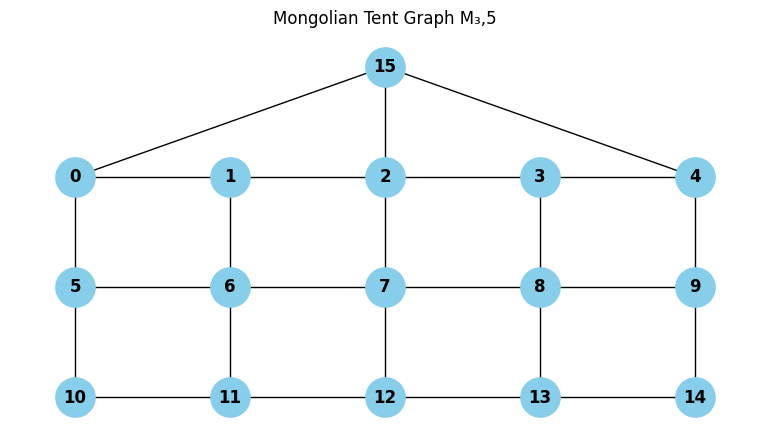

In [ ]:
def draw_graph(graph, n):
    G = nx.Graph(graph)
    pos = {}

    # Layout grid nodes (3 rows, n columns)
    for row in range(3):
        for col in range(n):
            node = row * n + col
            pos[node] = (col, -row)  # (x, y) coordinates

    # Layout tent peak above top row
    tent_peak = 3 * n
    pos[tent_peak] = ((n - 1) / 2, 1)  # Centered above the top row

    # Draw graph with given layout
    plt.figure(figsize=(1.5 * n, 4))
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=800, font_weight="bold")
    plt.title(f"Mongolian Tent Graph M₃,{n}")
    plt.axis("off")
    plt.show()

n = 5
graph = build_mongolian_tent_graph(n)
draw_graph(graph, n)